# Supervised Descriptors Benchmarking

## Importing libraries

In [6]:
## General
from __future__ import print_function 
import sys 
import pandas as pd
import numpy as np
from base64 import b64encode 
import types 

## Metrics

from sklearn.metrics import matthews_corrcoef as mcc
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix as cm

##Scaling

from sklearn.preprocessing import StandardScaler

## PLS supervised

from sklearn.cross_decomposition import PLSRegression

##RDKit Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate

from rdkit import Chem 
from rdkit import DataStructs 
from rdkit.Chem import Draw 
from rdkit.Chem.Draw import rdMolDraw2D 
from rdkit.Chem import SDWriter 
from rdkit.Chem import rdchem 
from rdkit.Chem.Scaffolds import MurckoScaffold 
from rdkit.six import BytesIO, string_types, PY3

from rdkit.Chem import PandasTools as pt
from rdkit.Chem import AllChem, Descriptors, Crippen, DataStructs

## time bar
from tqdm import tqdm

## Plots 

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
sns.set_style("ticks")

pd.options.display.max_columns = None
%config Completer.use_jedi=False

## Functions

In [2]:
def checkAtomsCoordinates(m):
    '''
        Function to check if a molecule contains zero coordinates in all atoms. 
        Then this molecule must be eliminated.
        Returns True if molecules is OK and False if molecule contains zero coordinates.
        
        Example:
            # Load  test set to a frame
            pfizersdf = 'validations_sets/pfizer-3Dprot-info.sdf'
            pfizer_val = pt.LoadSDF(pfizersdf, molColName='mol3DProt')
            ## Checking if molecule contains only ZERO coordinates, then remove that molecules from dataset
            pfizer_val['check_coordinates'] = [checkAtomsCoordinates(x) for x in pfizer_val.mol3DProt]
            pfizer_val_eliminated_mols = pfizer_val[pfizer_val.check_coordinates == False]
            pfizer_val = pfizer_val[pfizer_val.check_coordinates == True]
            pfizer_val.drop(columns=['check_coordinates'], inplace=True)
            print('final pfizer_val ltkbing set:', pfizer_val.shape[0])
            print('Sider pfizer_val elimnated:', pfizer_val_eliminated_mols.shape[0])

            ## Writing SD file of ltkb filtered dataframe
            pfizersdf = '../10-combination/2-ltkb/1-notmatch-testset/morganFP/ltkb_dissim_mfp_curated.sdf'

            pt.WriteSDF(pfizer_val, pfizersdf, properties = list(pfizer_val.columns), molColName='mol3DProt')
    '''
    conf = m.GetConformer()
    position = []
    for i in range(conf.GetNumAtoms()):
        pos = conf.GetAtomPosition(i)
        position.append([pos.x, pos.y, pos.z])
    position = np.array(position)
    if not np.any(position):
        return(False)
    else:
        return(True)

In [3]:
def mol2Dto3Drdkit(m, rmHs= True):

    '''
    
    Info
    ----

    Convert from 2D molecule to 3D using RDkit
    
    Parameters
    ----------
    
    m: rdkitmol  
        ## molecule in RDkit format
    rmHs: False 
        ## False if one wants to keep Hidrogens,True if you want to remove them. 
       
    Returns
    -------
    
    Molecule with 3D coordinates with or without hidrogens removed. 
    
    Example
    -------        

    df['mol3D'] = df.mol2D.apply(lambda x: mol2Dto3Drdkit(x, rmHs = True))

    '''

    m2 = AllChem.AddHs(m)
    AllChem.EmbedMolecule(m2,AllChem.ETKDG())
    if rmHs == False:
        return m2
    if rmHs == True:
        m3 = AllChem.RemoveHs(m2)
        return m3

In [4]:
def LoadSDFintoDF(filename, idName='ID', molColName='ROMol', includeFingerprints=False,
                  isomericSmiles=False, smilesName=None, embedProps=False):
    '''
        Read file in SDF format and return as Pandas data frame. 
        If embedProps=True all properties also get embedded in Mol objects in the molecule column. 
        If molColName=None molecules would not be present in resulting DataFrame (only properties 
        would be read). 
        I took that function from PandasTools and modified it eliminating the sanitize option and
        adding removeHs = False, cause I do not want the molecule to be modified. 
    ''' 

    if isinstance(filename, string_types):
        if filename.lower()[-3:] == ".gz":
            import gzip 
            f = gzip.open(filename, "rb") 
        else: 
            f = open(filename, 'rb') 
            close = f.close 
    else:
        f = filename
        close = None  # don't close an open file that was passed in 
    records = [] 
    indices = [] 
    for i, mol in enumerate(Chem.ForwardSDMolSupplier(f,removeHs=False)):
        if mol is None: 
            continue 
        row = dict((k, mol.GetProp(k)) for k in mol.GetPropNames()) 
        if molColName is not None and not embedProps: 
            for prop in mol.GetPropNames(): 
                  mol.ClearProp(prop) 
        if mol.HasProp('_Name'): 
            row[idName] = mol.GetProp('_Name') 
        if smilesName is not None: 
            row[smilesName] = Chem.MolToSmiles(mol, isomericSmiles=isomericSmiles) 
        if molColName is not None and not includeFingerprints: 
            row[molColName] = mol 
        elif molColName is not None: 
            row[molColName] = PandasTools._MolPlusFingerprint(mol) 
        records.append(row) 
        indices.append(i) 
   
    if close is not None:
        close() 
    pt.RenderImagesInAllDataFrames(images=True) 
    return pd.DataFrame(records, index=indices)

# 1. Dataset

In [7]:
traincols = pd.read_pickle('datasets/sider_curated.pkl').columns

In [8]:
train = LoadSDFintoDF('sdfs/sider.sdf', molColName='mol3DProt')
train = train[traincols]

In [51]:
biofpcols = train.loc[:,'Hepatitis':'Ascites'].columns.to_list()

In [14]:
## Creating ATC category descriptor

In [9]:
atc_cat = train[~train.atc_codes.str.contains(',')].cluster1.unique()
atc_cat = sorted(atc_cat) 
atc_cat

['A', 'B', 'C', 'D', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'V']

In [10]:
cats = []
for i in range(len(atc_cat)):
    cats.append(i)
cats

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [11]:
catdict = dict(zip(atc_cat, cats)) ## dictionary with category and color randomly asigned
# train["atc_category"] = [colordict[x] for x in train['cluster1'] else colordict[x]== 14]

In [58]:
mullinercols = pd.read_pickle('datasets/mulliner_overlap_sider_mfp.pkl').columns
lessdilirankcols = pd.read_pickle('datasets/lessdilirank_overlap_sider_mfp.pkl').columns
mostdilirankcols = pd.read_pickle('datasets/mostdilirank_overlap_sider_mfp.pkl').columns
pfizercols = pd.read_pickle('datasets/pfizer_overlap_sider_mfp.pkl').columns
obriencols = pd.read_pickle('datasets/obrien_overlap_sider_mfp.pkl').columns

mulliner_overlap_df = LoadSDFintoDF('sdfs/mulliner_overlap.sdf', molColName='mol3DProt')
mulliner_overlap_df = mulliner_overlap_df[mullinercols]
lessdilirank_overlap_df = LoadSDFintoDF('sdfs/lessdilirank_overlap.sdf', molColName='mol3DProt')
lessdilirank_overlap_df = lessdilirank_overlap_df[lessdilirankcols]
mostdilirank_overlap_df = LoadSDFintoDF('sdfs/mostdilirank_overlap.sdf', molColName='mol3DProt')
mostdilirank_overlap_df = mostdilirank_overlap_df[mostdilirankcols]
pfizer_overlap_df = LoadSDFintoDF('sdfs/pfizer_overlap.sdf', molColName='mol3DProt')
pfizer_overlap_df = pfizer_overlap_df[pfizercols]
obrien_overlap_df = LoadSDFintoDF('sdfs/obrien_overlap.sdf', molColName='mol3DProt')
obrien_overlap_df = obrien_overlap_df[obriencols]

In [59]:
obrien_overlap_df.rename(columns={'DILI positive/negative as observed':'vDILI'}, inplace = True)

In [60]:
pfizer_overlap_df.rename(columns={'activity':'vDILI'}, inplace = True)

In [61]:
frames = [mulliner_overlap_df, lessdilirank_overlap_df,
          mostdilirank_overlap_df,pfizer_overlap_df, obrien_overlap_df]

for f in frames:
    for x, row in f.iterrows():
        try:
            f.loc[x,'atc_category_MD'] = catdict[row['cluster1']]
        except:
            f.loc[x,'atc_category_MD']= 14

In [62]:
atc_categories_df = pd.DataFrame.from_dict({'A':[0,'ALIMENTARY TRACT AND METABOLISM'],
                        'B':[1, 'BLOOD AND BLOOD FORMING ORGANS'],
                        'C':[2,'CARDIOVASCULAR SYSTEM'],
                        'D':[3,'DERMATOLOGICALS'],
                        'G':[4,'GENITO URINARY SYSTEM AND SEX HORMONES'],
                        'H':[5, 'SYSTEMIC HORMONAL PREPARATIONS, EXCL. SEX HORMONES AND INSULINS'],
                        'J':[6,'ANTIINFECTIVES FOR SYSTEMIC USE'],
                        'L':[7,'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS'],
                        'M':[8,'MUSCULO-SKELETAL SYSTEM'],
                        'N':[9,'NERVOUS SYSTEM'],
                        'P':[10,'ANTIPARASITIC PRODUCTS, INSECTICIDES AND REPELLENTS'],
                        'R':[11,'RESPIRATORY SYSTEM'],
                        'S':[12,'SENSORY ORGANS'],
                        'V':[13,'VARIOUS'],
                        'Comb':[14, 'COMBINATION']}).T.reset_index()
atc_categories_df.columns = ['cat_label', 'cat_num', 'cat_description']
atc_categories_df

,cat_label,cat_num,cat_description
0,A,0,ALIMENTARY TRACT AND METABOLISM
1,B,1,BLOOD AND BLOOD FORMING ORGANS
2,C,2,CARDIOVASCULAR SYSTEM
3,D,3,DERMATOLOGICALS
4,G,4,GENITO URINARY SYSTEM AND SEX HORMONES
5,H,5,"SYSTEMIC HORMONAL PREPARATIONS, EXCL. SEX HORMONES AND INSULINS"
6,J,6,ANTIINFECTIVES FOR SYSTEMIC USE
7,L,7,ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS
8,M,8,MUSCULO-SKELETAL SYSTEM
9,N,9,NERVOUS SYSTEM


In [63]:
mulliner_overlap_df = pd.merge(mulliner_overlap_df, atc_categories_df, how='left',
                               left_on='atc_category_MD', right_on='cat_num')
lessdilirank_overlap_df = pd.merge(lessdilirank_overlap_df, atc_categories_df, how='left',
                                   left_on='atc_category_MD', right_on='cat_num')
mostdilirank_overlap_df = pd.merge(mostdilirank_overlap_df, atc_categories_df, how='left',
                                   left_on='atc_category_MD', right_on='cat_num')
pfizer_overlap_df = pd.merge(pfizer_overlap_df, atc_categories_df, how='left',
                             left_on='atc_category_MD', right_on='cat_num')
obrien_overlap_df = pd.merge(obrien_overlap_df, atc_categories_df, how='left',
                             left_on='atc_category_MD', right_on='cat_num')



,parent_nonstd_inkey,atc_names,mol3DProt,cat_label,cat_description,vDILI,cat_num,Hepatitis,Jaundice,Hepatobiliary disease,Hepatic failure,Hepatic function abnormal,Hepatocellular injury,Jaundice cholestatic,Hyperbilirubinaemia,Liver injury,Cholestasis,Hepatotoxicity,Hepatomegaly,Liver disorder,Hepatic necrosis,Cholelithiasis,Cholecystitis,Foetor hepaticus,Hepatitis cholestatic,Ascites
0,AFCGFAGUEYAMAO-CEFIVFJTNA-M,acamprosate,,N,NERVOUS SYSTEM,1,9,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1

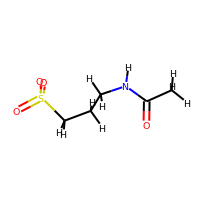

In [67]:
mulliner_overlap_df.head(1)

In [65]:
biofpcols = mulliner_overlap_df.loc[:,'Hepatitis':'Ascites'].columns.to_list()

In [66]:
cols = ['parent_nonstd_inkey', 'atc_names', 'mol3DProt', 'cat_label', 'cat_description', 'vDILI', 'cat_num']
mulliner_overlap_df = mulliner_overlap_df[cols+biofpcols]
lessdilirank_overlap_df = lessdilirank_overlap_df[cols+biofpcols]
mostdilirank_overlap_df = mostdilirank_overlap_df[cols+biofpcols]
pfizer_overlap_df = pfizer_overlap_df[cols+biofpcols]
obrien_overlap_df = obrien_overlap_df[cols+biofpcols]

# 3. Descriptors

## 3.1. Morgan Fingerprints

In [68]:
def calc_fp( mols, radius, features ):

    '''
    Info
    ----
    This function allows one to calculate morgan fingerprints from a list of molecules
    
    Parameters
    ----------
    
    radius: int
        e.g. radius = 4 ## define morgan fingerprint radius 
    mols: RDKit molecule
        e.g. mols = df.mol3DProt ## dataframe column containing molecules
    
    Return
    ------
    
    morgan fingerprints array
    
    Example
    -------
    
    mfp = calc_fp_arr( mols , radius)

    Attention
    ---------
    
    If this function doesn't work, try to update your conda environment
    
    '''

    fplist = []
    for mol in mols:
        arr = np.zeros( (1,) )
        fp = AllChem.GetMorganFingerprintAsBitVect( mol, int(radius),useFeatures=True)
        DataStructs.ConvertToNumpyArray( fp, arr )
        fplist.append( arr )
    fp_df = pd.DataFrame(fplist)
    cols = [str('MorganFP%0.4d'%(int(x)+1)) for x in range(fp_df.shape[1])]
    fp_df.columns = cols 
    return (fp_df)

In [109]:
mulliner_fp_overlap_df = calc_fp(mulliner_overlap_df.mol3DProt,3,True)
mulliner_fp_overlap_df.reset_index(drop=True, inplace =True)
mulliner_fp_overlap_df = mulliner_overlap_df.join(mulliner_fp_overlap_df)

,parent_nonstd_inkey,atc_names,mol3DProt,cat_label,cat_description,vDILI,cat_num,Hepatitis,Jaundice,Hepatobiliary disease,Hepatic failure,Hepatic function abnormal,Hepatocellular injury,Jaundice cholestatic,Hyperbilirubinaemia,Liver injury,Cholestasis,Hepatotoxicity,Hepatomegaly,Liver disorder,Hepatic necrosis,Cholelithiasis,Cholecystitis,Foetor hepaticus,Hepatitis cholestatic,Ascites,MorganFP0001,MorganFP0002,MorganFP0003,MorganFP0004,MorganFP0005,MorganFP0006,MorganFP0007,MorganFP0008,MorganFP0009,MorganFP0010,MorganFP0011,MorganFP0012,MorganFP0013,MorganFP0014,MorganFP0015,MorganFP0016,MorganFP0017,MorganFP0018,MorganFP0019,MorganFP0020,MorganFP0021,MorganFP0022,MorganFP0023,MorganFP0024,MorganFP0025,MorganFP0026,MorganFP0027,MorganFP0028,MorganFP0029,MorganFP0030,MorganFP0031,MorganFP0032,MorganFP0033,MorganFP0034,MorganFP0035,MorganFP0036,MorganFP0037,MorganFP0038,MorganFP0039,MorganFP0040,MorganFP0041,MorganFP0042,MorganFP0043,MorganFP0044,MorganFP0045,MorganFP0046,MorganFP0047,MorganFP0048,MorganFP0049,MorganFP0050,MorganFP0051,MorganFP0052,MorganFP0053,MorganFP0054,MorganFP0055,MorganFP0056,MorganFP0057,MorganFP0058,MorganFP0059,MorganFP0060,MorganFP0061,MorganFP0062,MorganFP0063,MorganFP0064,MorganFP0065,MorganFP0066,MorganFP0067,MorganFP0068,MorganFP0069,MorganFP0070,MorganFP0071,MorganFP0072,MorganFP0073,MorganFP0074,MorganFP0075,MorganFP0076,MorganFP0077,MorganFP0078,MorganFP0079,MorganFP0080,MorganFP0081,MorganFP0082,MorganFP0083,MorganFP0084,MorganFP0085,MorganFP0086,MorganFP0087,MorganFP0088,MorganFP0089,MorganFP0090,MorganFP0091,MorganFP0092,MorganFP0093,MorganFP0094,MorganFP0095,MorganFP0096,MorganFP0097,MorganFP0098,MorganFP0099,MorganFP0100,MorganFP0101,MorganFP0102,MorganFP0103,MorganFP0104,MorganFP0105,MorganFP0106,MorganFP0107,MorganFP0108,MorganFP0109,MorganFP0110,MorganFP0111,MorganFP0112,MorganFP0113,MorganFP0114,MorganFP0115,MorganFP0116,MorganFP0117,MorganFP0118,MorganFP0119,MorganFP0120,MorganFP0121,MorganFP0122,MorganFP0123,MorganFP0124,MorganFP0125,MorganFP0126,MorganFP0127,MorganFP0128,MorganFP0129,MorganFP0130,MorganFP0131,MorganFP0132,MorganFP0133,MorganFP0134,MorganFP0135,MorganFP0136,MorganFP0137,MorganFP0138,MorganFP0139,MorganFP0140,MorganFP0141,MorganFP0142,MorganFP0143,MorganFP0144,MorganFP0145,MorganFP0146,MorganFP0147,MorganFP0148,MorganFP0149,MorganFP0150,MorganFP0151,MorganFP0152,MorganFP0153,MorganFP0154,MorganFP0155,MorganFP0156,MorganFP0157,MorganFP0158,MorganFP0159,MorganFP0160,MorganFP0161,MorganFP0162,MorganFP0163,MorganFP0164,MorganFP0165,MorganFP0166,MorganFP0167,MorganFP0168,MorganFP0169,MorganFP0170,MorganFP0171,MorganFP0172,MorganFP0173,MorganFP0174,MorganFP0175,MorganFP0176,MorganFP0177,MorganFP0178,MorganFP0179,MorganFP0180,MorganFP0181,MorganFP0182,MorganFP0183,MorganFP0184,MorganFP0185,MorganFP0186,MorganFP0187,MorganFP0188,MorganFP0189,MorganFP0190,MorganFP0191,MorganFP0192,MorganFP0193,MorganFP0194,MorganFP0195,MorganFP0196,MorganFP0197,MorganFP0198,MorganFP0199,MorganFP0200,MorganFP0201,MorganFP0202,MorganFP0203,MorganFP0204,MorganFP0205,MorganFP0206,MorganFP0207,MorganFP0208,MorganFP0209,MorganFP0210,MorganFP0211,MorganFP0212,MorganFP0213,MorganFP0214,MorganFP0215,MorganFP0216,MorganFP0217,MorganFP0218,MorganFP0219,MorganFP0220,MorganFP0221,MorganFP0222,MorganFP0223,MorganFP0224,MorganFP0225,MorganFP0226,MorganFP0227,MorganFP0228,MorganFP0229,MorganFP0230,MorganFP0231,MorganFP0232,MorganFP0233,MorganFP0234,MorganFP0235,MorganFP0236,MorganFP0237,MorganFP0238,MorganFP0239,MorganFP0240,MorganFP0241,MorganFP0242,MorganFP0243,MorganFP0244,MorganFP0245,MorganFP0246,MorganFP0247,MorganFP0248,MorganFP0249,MorganFP0250,MorganFP0251,MorganFP0252,MorganFP0253,MorganFP0254,MorganFP0255,MorganFP0256,MorganFP0257,MorganFP0258,MorganFP0259,MorganFP0260,MorganFP0261,MorganFP0262,MorganFP0263,MorganFP0264,MorganFP0265,MorganFP0266,MorganFP0267,MorganFP0268,MorganFP0269,MorganFP0270,MorganFP0271,MorganFP0272,MorganFP0273,MorganFP0274,MorganFP0275,MorganFP0276,MorganFP0277,MorganFP027
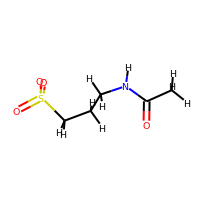
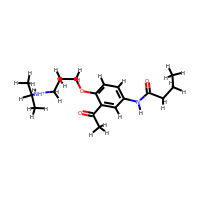

In [110]:
mulliner_fp_overlap_df.head(2)

In [111]:
mostdilirank_fp_overlap_df = calc_fp(mostdilirank_overlap_df.mol3DProt,3,True)
mostdilirank_fp_overlap_df.reset_index(drop=True, inplace =True)
mostdilirank_fp_overlap_df = mostdilirank_overlap_df.join(mostdilirank_fp_overlap_df)

In [112]:
lessdilirank_fp_overlap_df = calc_fp(lessdilirank_overlap_df.mol3DProt,3,True)
lessdilirank_fp_overlap_df.reset_index(drop=True, inplace =True)
lessdilirank_fp_overlap_df = lessdilirank_overlap_df.join(lessdilirank_fp_overlap_df)

In [113]:
pfizer_fp_overlap_df = calc_fp(pfizer_overlap_df.mol3DProt,3,True)
pfizer_fp_overlap_df.reset_index(drop=True, inplace =True)
pfizer_fp_overlap_df = pfizer_overlap_df.join(pfizer_fp_overlap_df)

In [114]:
obrien_fp_overlap_df = calc_fp(obrien_overlap_df.mol3DProt,3,True)
obrien_fp_overlap_df.reset_index(drop=True, inplace =True)
obrien_fp_overlap_df = obrien_overlap_df.join(obrien_fp_overlap_df)

In [115]:
fpcols = mulliner_fp_overlap_df.loc[:,'MorganFP0001':].columns.to_list()

## 3.2. Pharmacophoric Fingerprints

In [99]:
def calc_phfp( mols ):

    '''
    Info
    ----
    This function allows one to calculate 200 RDKit Molecular Descriptors
    from a list of molecules
    
    Parameters
    ----------
 
    mols: RDKit molecule
        e.g. mols = df.mol3DProt ## dataframe column containing molecules
    
    Return
    ------
    
    RDKit descriptors pandas Dataframe array
    
    Example
    -------
    
    fp_df = calc_rdkitmd( mols )

    Attention
    ---------
    
    If this function doesn't work, try to update your conda environment
    
    '''
    factory = Gobbi_Pharm2D.factory    
    fplist = []
    for mol in mols:
        arr = np.zeros( (1,) )
        fp = Generate.Gen2DFingerprint(mol, factory, dMat=Chem.Get3DDistanceMatrix(mol))
        fp = DataStructs.ConvertToExplicit(fp)
        DataStructs.ConvertToNumpyArray( fp, arr )
        fplist.append( arr )
    fp_df = pd.DataFrame(fplist)
    cols = [str('phFP%0.4d'%(int(x)+1)) for x in range(fp_df.shape[1])]
    fp_df.columns = cols
    
    return (fp_df)

In [117]:
mulliner_phfp_overlap_df = calc_phfp(mulliner_overlap_df.mol3DProt)
mulliner_phfp_overlap_df.reset_index(drop=True, inplace =True)
phfpcols = mulliner_phfp_overlap_df.loc[:,'phFP0001':].columns
mulliner_alldesc_df = mulliner_fp_overlap_df.join(mulliner_phfp_overlap_df[phfpcols])

In [120]:
mostdilirank_phfp_overlap_df = calc_phfp(mostdilirank_overlap_df.mol3DProt)
mostdilirank_phfp_overlap_df.reset_index(drop=True, inplace =True)
mostdilirank_alldesc_df = mostdilirank_fp_overlap_df.join(mostdilirank_phfp_overlap_df[phfpcols])

In [121]:
lessdilirank_phfp_overlap_df = calc_phfp(lessdilirank_overlap_df.mol3DProt)
lessdilirank_phfp_overlap_df.reset_index(drop=True, inplace =True)
lessdilirank_alldesc_df = lessdilirank_fp_overlap_df.join(lessdilirank_phfp_overlap_df[phfpcols])

In [122]:
pfizer_phfp_overlap_df = calc_phfp(pfizer_overlap_df.mol3DProt)
pfizer_phfp_overlap_df.reset_index(drop=True, inplace =True)
pfizer_alldesc_df = pfizer_fp_overlap_df.join(pfizer_phfp_overlap_df[phfpcols])

In [123]:
obrien_phfp_overlap_df = calc_phfp(obrien_overlap_df.mol3DProt)
obrien_phfp_overlap_df.reset_index(drop=True, inplace =True)
obrien_alldesc_df = obrien_fp_overlap_df.join(obrien_phfp_overlap_df[phfpcols])

## 3.3. Merging all descriptors in a single dataframe per validation set

In [ ]:
mulliner_md_overlap_df = pd.read_pickle('descriptors/sider_overlap/mulliner_md_overlap.pkl')
mdcols = mulliner_md_overlap_df.loc[:,'MaxEStateIndex':].columns
mulliner_alldesc_df = mulliner_alldesc_df.join(mulliner_md_overlap_df[mdcols])
mulliner_vsurf_overlap_df = pd.read_csv('descriptors/sider_overlap/mulliner_overlap_Volsurf.csv', sep='\t')
vsmdcols = mulliner_vsurf_overlap_df.loc[:,'V':].columns
mulliner_alldesc_df = mulliner_alldesc_df.join(mulliner_vsurf_overlap_df[vsmdcols])

In [128]:
# mulliner_fp_overlap_df = pd.read_pickle('descriptors/sider_overlap/mulliner_fp_overlap.pkl')
# mulliner_phfp_overlap_df = pd.read_pickle('descriptors/sider_overlap/mulliner_phfp_overlap.pkl')


# lessdilirank_fp_overlap_df = pd.read_pickle('descriptors/sider_overlap/lessdilirank_fp_overlap.pkl')
# lessdilirank_phfp_overlap_df = pd.read_pickle('descriptors/sider_overlap/lessdilirank_phfp_overlap.pkl')
lessdilirank_md_overlap_df = pd.read_pickle('descriptors/sider_overlap/lessdilirank_md_overlap.pkl')
lessdilirank_alldesc_df = lessdilirank_alldesc_df.join(lessdilirank_md_overlap_df[mdcols])
lessdilirank_vsurf_overlap_df = pd.read_csv('descriptors/sider_overlap/lessdilirank_overlap_Volsurf.csv', sep='\t')
lessdilirank_alldesc_df = lessdilirank_alldesc_df.join(lessdilirank_vsurf_overlap_df[vsmdcols])
# mostdilirank_fp_overlap_df = pd.read_pickle('descriptors/sider_overlap/mostdilirank_fp_overlap.pkl')
# mostdilirank_phfp_overlap_df = pd.read_pickle('descriptors/sider_overlap/mostdilirank_phfp_overlap.pkl')
mostdilirank_md_overlap_df = pd.read_pickle('descriptors/sider_overlap/mostdilirank_md_overlap.pkl')
mostdilirank_alldesc_df = mostdilirank_alldesc_df.join(mostdilirank_md_overlap_df[mdcols])
mostdilirank_vsurf_overlap_df = pd.read_csv('descriptors/sider_overlap/mostdilirank_overlap_Volsurf.csv', sep='\t')
mostdilirank_alldesc_df = mostdilirank_alldesc_df.join(mostdilirank_vsurf_overlap_df[vsmdcols])
# pfizer_fp_overlap_df = pd.read_pickle('descriptors/sider_overlap/pfizer_fp_overlap.pkl')
# pfizer_phfp_overlap_df = pd.read_pickle('descriptors/sider_overlap/pfizer_phfp_overlap.pkl')
pfizer_md_overlap_df = pd.read_pickle('descriptors/sider_overlap/pfizer_md_overlap.pkl')
pfizer_alldesc_df = pfizer_alldesc_df.join(pfizer_md_overlap_df[mdcols])
pfizer_vsurf_overlap_df = pd.read_csv('descriptors/sider_overlap/pfizer_overlap_Volsurf.csv', sep='\t')
pfizer_alldesc_df = pfizer_alldesc_df.join(pfizer_vsurf_overlap_df[vsmdcols])
# obrien_fp_overlap_df = pd.read_pickle('descriptors/sider_overlap/obrien_fp_overlap.pkl')
# obrien_phfp_overlap_df = pd.read_pickle('descriptors/sider_overlap/obrien_phfp_overlap.pkl')
obrien_md_overlap_df = pd.read_pickle('descriptors/sider_overlap/obrien_md_overlap.pkl')
obrien_alldesc_df = obrien_alldesc_df.join(obrien_md_overlap_df[mdcols])
obrien_vsurf_overlap_df = pd.read_csv('descriptors/sider_overlap/obrien_overlap_Volsurf.csv', sep='\t')
obrien_alldesc_df = obrien_alldesc_df.join(obrien_vsurf_overlap_df[vsmdcols])

In [135]:
mulliner_alldesc_df.to_pickle('datasets_plus_descriptors/mulliner.pkl.gz', compression='gzip')
lessdilirank_alldesc_df.to_pickle('datasets_plus_descriptors/lessdilirank.pkl.gz', compression='gzip')
mostdilirank_alldesc_df.to_pickle('datasets_plus_descriptors/mostdilirank.pkl.gz', compression='gzip')
pfizer_alldesc_df.to_pickle('datasets_plus_descriptors/pfizer.pkl.gz', compression='gzip')
obrien_alldesc_df.to_pickle('datasets_plus_descriptors/obrien.pkl.gz', compression='gzip')

# 4. PLS coefficients calculation.

In [174]:
def get_pls_coeff_df(df, dcols, actcol, testname):
    
    ### Defining X and Y variables
    X = df[dcols].values
    Y = df[actcol].values
    
    scaler = StandardScaler()
    scaler.fit(X)
    Xs = scaler.transform(X)
    
    # Running PLSregression from sklearn
    pls = PLSRegression(n_components=2, scale=True)
    projection = pls.fit_transform(X=Xs,y=Y)
#     y_pred = cross_val_predict(estimator, X, Y, cv=10, n_jobs=1)
    
#     # Getting scores and coefficients
#     score = projection[0][:, 0:2]
#     coeff = pls.x_loadings_
#     coeff_y = pls.y_loadings_[0]
#     labels = x
    
    testpls_coef = pls.coef_
#     testpls_coef = pls.x_loadings_
#     testpls_coef = pls.x_weights_
    
    # Creating Dataframe with coefficients, endpoint and source information sorted by coefficients.
    frame = pd.DataFrame(columns=['coef', 'descriptors'])
    frame['coef'] = testpls_coef[:, 0]
    frame['descriptors'] = dcols

#     frame = frame.sort_values(by='coef', ascending=False).reset_index(drop=True)
    frame['source'] = testname
    
    return (frame)

In [138]:
len(fpcols), len(phfpcols), len(mdcols), len(biofpcols), len(vsmdcols)

(2048, 39972, 200, 19, 128)

In [151]:
fpcols = list(fpcols)
phfpcols = list(phfpcols)
mdcols = list(mdcols)
biofpcols = list(biofpcols)
vsmdcols = list(vsmdcols)
c1 = fpcols+mdcols
c2 = fpcols+vsmdcols
c3 = fpcols+biofpcols
c4 = fpcols+mdcols+biofpcols
c5 = fpcols+vsmdcols+biofpcols
c6 = phfpcols+mdcols
c7 = phfpcols+vsmdcols
c8 = phfpcols+biofpcols
c9 = phfpcols+mdcols+biofpcols
c10 = phfpcols+vsmdcols+biofpcols
c11 = mdcols+biofpcols
c12 = vsmdcols+biofpcols

In [151]:
fpcols = list(fpcols)
phfpcols = list(phfpcols)
mdcols = list(mdcols)
biofpcols = list(biofpcols)
# vsmdcols = list(vsmdcols)
c1 = fpcols+mdcols
# c2 = fpcols+vsmdcols
c3 = fpcols+biofpcols
c4 = fpcols+mdcols+biofpcols
c5 = fpcols+vsmdcols+biofpcols
c6 = phfpcols+mdcols
# c7 = phfpcols+vsmdcols
c8 = phfpcols+biofpcols
c9 = phfpcols+mdcols+biofpcols
# c10 = phfpcols+vsmdcols+biofpcols
c11 = mdcols+biofpcols
# c12 = vsmdcols+biofpcols

In [153]:
mostdilirank_alldesc_df.fillna(value=0, inplace=True)

In [374]:
dcols = [fpcols, phfpcols, mdcols,biofpcols,
         c1, c3, c4, c5, c6, c8, c9, c11]

dnames = ['morganfp','phfp','rdkit','biofp',
          'morganfp_rdkit','morganfp_biofp',
          'morganfp_rdkit_biofp',
          'phfp_rdkit','phfp_biofp',
          'phfp_rdkit_biofp',
          'rdkit_biofp']
coefsDF = pd.DataFrame([])
for i, j in zip(dcols, dnames):
    frame = get_pls_coeff_df(mostdilirank_alldesc_df, i, 'vDILI', j)
    coefsDF = coefsDF.append(frame)

/home/kpinto/miniconda3/envs/flame/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kpinto/miniconda3/envs/flame/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kpinto/miniconda3/envs/flame/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kpinto/miniconda3/envs/flame/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kpinto/miniconda3/envs/flame/lib/python3.6/site-pa

In [175]:
dcols = [fpcols, phfpcols, mdcols, vsmdcols, biofpcols,
         c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12]

dnames = ['morganfp','phfp','rdkit', 'volsurf', 'biofp',
          'morganfp_rdkit','morganfp_vsurf', 'morganfp_biofp',
          'morganfp_rdkit_biofp','morganfp_vsurf_biofp',
          'phfp_rdkit','phfp_vsurf', 'phfp_biofp',
          'phfp_rdkit_biofp','phfp_vsurf_biofp',
          'rdkit_biofp', 'vsurf_biofp']
coefsDF = pd.DataFrame([])
for i, j in zip(dcols, dnames):
    frame = get_pls_coeff_df(mostdilirank_alldesc_df, i, 'vDILI', j)
    coefsDF = coefsDF.append(frame)

/home/kpinto/miniconda3/envs/flame/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kpinto/miniconda3/envs/flame/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kpinto/miniconda3/envs/flame/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kpinto/miniconda3/envs/flame/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kpinto/miniconda3/envs/flame/lib/python3.6/site-pa

In [176]:
coefsDF.head(2)

,coef,descriptors,source
0,0.004072,MorganFP0001,morganfp
1,0.000898,MorganFP0002,morganfp


In [375]:
coefsDF.source.nunique()

11

In [178]:
coefsDF.head(2)

,coef,descriptors,source
0,0.004072,MorganFP0001,morganfp
1,0.000898,MorganFP0002,morganfp


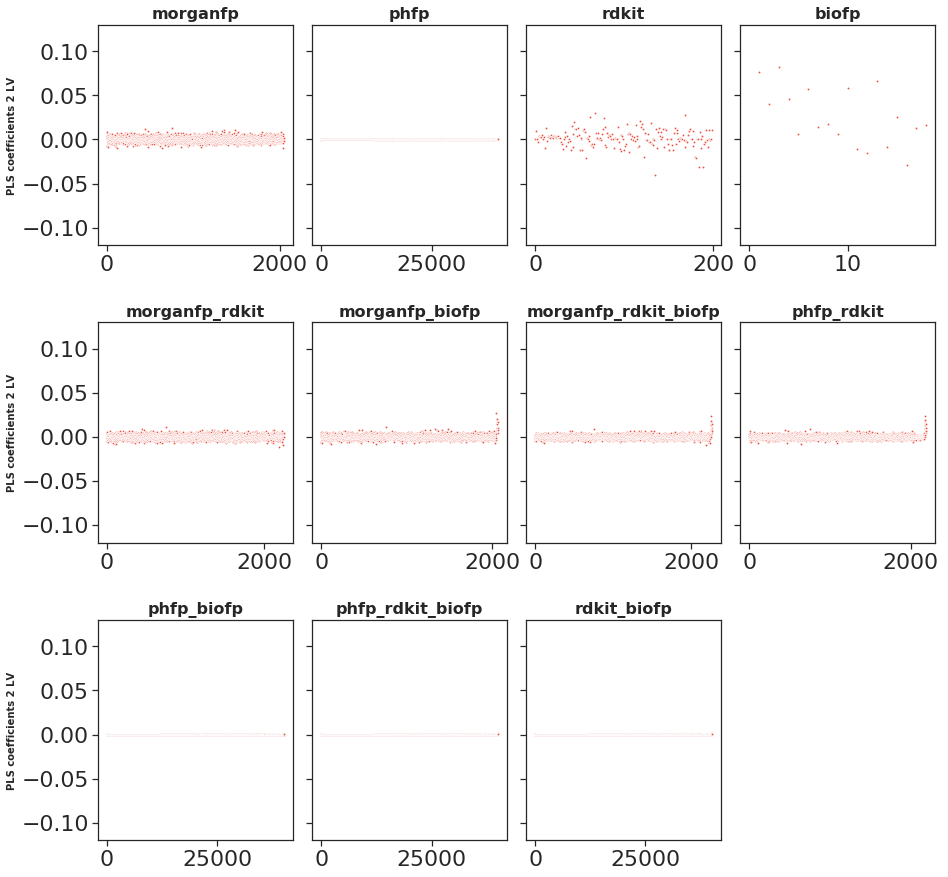

In [378]:
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 22}

# plt.rc('font', **font)

sns.set(font_scale = 2.0)
sns.set_style("ticks")
mypal = ["#e74c3c"]
sns.set_palette(mypal)

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8),
      (ax9, ax10, ax11,ax12)) = plt.subplots(3,4, sharey=True, sharex=False, figsize=(15,15))
fig.subplots_adjust(hspace=0.35, wspace=0.1)

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]

df1 = coefsDF.copy()
# plt.figure(figsize=(20,10))
# x = np.arange(df1.source.nunique())
# ys = [i+x+(i*x)**2 for i in range(df1.source.nunique())]
# colors = cm.rainbow(np.linspace(0, 1, len(ys)))

for i, j in zip(df1.source.unique(), axes):
    df = df1.copy()
    df = df[df.source.isin([i])]
    df.reset_index(inplace=True) 
    ax = sns.scatterplot(data=df, x='index', y='coef',ax=j, s=7,markers='.',legend=None)
#     ax.set_xlim(0,2600)
    ax.set_ylim(-0.12,0.13)
    ax.set_xlabel('')
#     ax.xaxis.set_ticks(np.arange(0, 35000, step=200))
#     ax.set_xticklabels(np.arange(0, 2700, step=200), rotation=90, fontsize=10)
#     ax.yaxis.set_ticks(np.arange(-0.12, 0.14, step=0.02))
#     ax.set_yticklabels(np.around(np.arange(-0.12, 0.14, step=0.02),decimals=2), fontsize=10)
    ax.set_title(i, fontsize=16, fontweight='bold')
    ax.set_ylabel('PLS coefficients 2 LV', fontsize=10, fontweight='bold')
    if i in [ax8, ax9, ax10, ax11]:
        ax.set_xlabel('descriptors', fontsize=16, fontweight='bold')
    
fig.delaxes(ax12)

fig.savefig("figures/PLS_md_combination.png", bbox_inches="tight")

In [330]:
okcols = [fpcols, mdcols, biofpcols,
         c1, c3, c4, c11]

oknames = ['morganfp','rdkit', 'biofp',
          'morganfp_rdkit','morganfp_biofp',
          'morganfp_rdkit_biofp',
          'rdkit_biofp']

In [181]:
coefsDF.head()

,coef,descriptors,source
0,0.004072,MorganFP0001,morganfp
1,0.000898,MorganFP0002,morganfp
2,0.003837,MorganFP0003,morganfp
3,-0.007305,MorganFP0004,morganfp
4,0.001825,MorganFP0005,morganfp


# 5. Similarity metrics analysis.

## 5.1. Functions

In [197]:
def get_similarity(df, sourceID, targetID, coefsdf, dcols, ):
    
    ## Similarity distance functions
    simt = lambda a, b: (1-(distance.jaccard(a,b)/dmax))
    sime = lambda a, b: (1-(distance.euclidean(a,b)/dmax))
    simc = lambda a, b: (1-(distance.cosine(a,b)/dmax))
    simm = lambda a, b: (1-(distance.cityblock(a,b)/dmax))
#     sims = lambda a, b: (1-(distance.sokalmichener(a,b)/dmax))
    
    sims = [simt, sime, simc, simm]
    simsname = ['jaccard', 'euclidean', 'cosine', 'cityblock']
    simDF = pd.DataFrame([])
    for i,j in zip(sims, simsname):
        coefs = coefsdf[coefsdf.source == 'no_random_noise'].T.head(2)
        coefs.columns = coefs.loc['descriptors',:].values
        coefs = coefs.head(1)
        coefs.reset_index(drop=True, inplace=True)
        cdf = pd.DataFrame([])
        for k, row in df.iterrows():
            tempdf = coefs.loc[[0], :]*df.loc[[k],coefs.columns].values
            cdf = cdf.append(tempdf)
        cdf.reset_index(drop=True,inplace=True)
        ydist = distance.pdist(np.array(cdf[coefs.columns].astype(float)), metric=j)
        dmax = np.percentile(ydist,95)
        tdf = cdf[coefs.columns].astype(float).transpose().reset_index(drop=True)
        tdf.columns = list(df[sourceID])

        # ## Correlation matrix
        corrdf = tdf.corr(method=i)
        scorrdf = corrdf.stack().reset_index()
        scorrdf.columns = [sourceID+'_source', targetID+'_target', 'sim'+j]
        if j == 'jaccard':
            simDF = simDF.append(scorrdf)
        else:
            simDF.loc[:,'sim'+j] = scorrdf.loc[:,'sim'+j]
        for rdnum in tqdm(rand):
            if rdnum == 0:
                continue
            coefs = coefsdf[coefsdf.source == str('rand%0.4d'%(rdnum))].T.head(2)
            coefs.columns = coefs.loc['descriptors',:].values
            coefs = coefs.head(1)
            coefs.reset_index(drop=True, inplace=True)
            cdf = pd.DataFrame([])
            for l, row in df.iterrows():
                tempdf = coefs.loc[[0], :]*df.loc[[l],coefs.columns].values
                cdf = cdf.append(tempdf)
            cdf.reset_index(drop=True,inplace=True)
            ydist = distance.pdist(np.array(cdf[coefs.columns].astype(float)), metric=j)
            dmax = np.percentile(ydist,95)
            tdf = cdf[coefs.columns].astype(float).transpose().reset_index(drop=True)
            tdf.columns = list(df[sourceID])

            # ## Correlation matrix
            corrdf = tdf.corr(method=i)
            scorrdf = corrdf.stack().reset_index()
            scorrdf.columns = [sourceID+'_source', targetID+'_target', 'sim'+j+str('rand%0.4d'%(rdnum))]
#             if j == 'jaccard':
#                 simDF = simDF.append(scorrdf)
#             else:
            simDF.loc[:,'sim'+j+str('rand%0.4d'%(rdnum))] = scorrdf.loc[:,'sim'+j+str('rand%0.4d'%(rdnum))]
    return(simDF)

In [203]:
def get_similarity(df, sourceID, targetID, coefsdf, dnames):
    
    ## Similarity distance functions
    simt = lambda a, b: (1-(distance.jaccard(a,b)/dmax))
    sime = lambda a, b: (1-(distance.euclidean(a,b)/dmax))
    simc = lambda a, b: (1-(distance.cosine(a,b)/dmax))
    simm = lambda a, b: (1-(distance.cityblock(a,b)/dmax))
#     sims = lambda a, b: (1-(distance.sokalmichener(a,b)/dmax))
    
    sims = [simt, sime, simc, simm]
    simsname = ['jaccard', 'euclidean', 'cosine', 'cityblock']
    simDF = pd.DataFrame([])
    for i,j in zip(sims, simsname):
        for k in tqdm(dnames):
            coefs = coefsdf[coefsdf.source == k].T.head(2)
            coefs.columns = coefs.loc['descriptors',:].values
            coefs = coefs.head(1)
            coefs.reset_index(drop=True, inplace=True)
            cdf = pd.DataFrame([])
            for l, row in df.iterrows():
                tempdf = coefs.loc[[0], :].astype(float)*df.loc[[l],coefs.columns].astype(float).values
                cdf = cdf.append(tempdf)
            cdf.reset_index(drop=True,inplace=True)
            ydist = distance.pdist(np.array(cdf[coefs.columns].astype(float)), metric=j)
            dmax = np.percentile(ydist,95)
            tdf = cdf[coefs.columns].astype(float).transpose().reset_index(drop=True)
            tdf.columns = list(df[sourceID])

            # ## Correlation matrix
            corrdf = tdf.corr(method=i)
            scorrdf = corrdf.stack().reset_index()
            scorrdf.columns = [sourceID+'_source', targetID+'_target', j+'_'+k]
            if j+'_'+k == 'jaccard_morganfp':
                simDF = simDF.append(scorrdf)
            else:
                simDF.loc[:,j+'_'+k] = scorrdf.loc[:,j+'_'+k]
    return(simDF)

## 5.2. Calculate Fingerprints Similarity between reference and test set.

In [204]:
df = mostdilirank_alldesc_df.copy()
sourceID = 'parent_nonstd_inkey'
targetID = 'parent_nonstd_inkey'
# dcols = dcols
simDF = get_similarity(df, sourceID, targetID, coefsDF, oknames)


100%|██████████| 11/11 [01:15<00:00,  6.98s/it]

In [205]:
simDF.head(2)

,parent_nonstd_inkey_source,parent_nonstd_inkey_target,jaccard_morganfp,jaccard_rdkit,jaccard_volsurf,jaccard_biofp,jaccard_morganfp_rdkit,jaccard_morganfp_vsurf,jaccard_morganfp_biofp,jaccard_morganfp_rdkit_biofp,jaccard_morganfp_vsurf_biofp,jaccard_rdkit_biofp,jaccard_vsurf_biofp,euclidean_morganfp,euclidean_rdkit,euclidean_volsurf,euclidean_biofp,euclidean_morganfp_rdkit,euclidean_morganfp_vsurf,euclidean_morganfp_biofp,euclidean_morganfp_rdkit_biofp,euclidean_morganfp_vsurf_biofp,euclidean_rdkit_biofp,euclidean_vsurf_biofp,cosine_morganfp,cosine_rdkit,cosine_volsurf,cosine_biofp,cosine_morganfp_rdkit,cosine_morganfp_vsurf,cosine_morganfp_biofp,cosine_morganfp_rdkit_biofp,cosine_morganfp_vsurf_biofp,cosine_rdkit_biofp,cosine_vsurf_biofp,cityblock_morganfp,cityblock_rdkit,cityblock_volsurf,cityblock_biofp,cityblock_morganfp_rdkit,cityblock_morganfp_vsurf,cityblock_morganfp_biofp,cityblock_morganfp_rdkit_biofp,cityblock_morganfp_vsurf_biofp,cityblock_rdkit_biofp,cityblock_vsurf_biofp
0,AEUTYOVWOVBAKS-YWVQUKSWNA-O,AEUTYOVWOVBAKS-YWVQUKSWNA-O,1.000000,1.0000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,AEUTYOVWOVBAKS-YWVQUKSWNA-O,AGOYDEPGAOXOCK-YDSUDHQVNA-O,0.092409,0.1875,0.0,0.2,0.146093,0.040263,0.099099,0.141989,0.046018,0.175506,0.015038,0.184938,0.286258,0.478306,0.271477,0.345875,0.376856,0.191268,0.247518,0.384914,0.228756,0.441523,0.428121,0.282921,1.0,1.0,0.336765,0.774417,0.52086,0.449778,0.772537,0.460831,1.0,0.314488,0.354027,0.528876,0.333886,0.265443,0.455579,0.248037,0.192005,0.461965,0.224562,0.489503


In [311]:
simcols = simDF.columns[~simDF.columns.str.contains('parent')]
simcols = simcols[~simcols.str.contains('volsurf')]
simcols = simcols[~simcols.str.contains('vsurf')].to_list()
simcols

['jaccard_morganfp',
 'jaccard_rdkit',
 'jaccard_biofp',
 'jaccard_morganfp_rdkit',
 'jaccard_morganfp_biofp',
 'jaccard_morganfp_rdkit_biofp',
 'jaccard_rdkit_biofp',
 'euclidean_morganfp',
 'euclidean_rdkit',
 'euclidean_biofp',
 'euclidean_morganfp_rdkit',
 'euclidean_morganfp_biofp',
 'euclidean_morganfp_rdkit_biofp',
 'euclidean_rdkit_biofp',
 'cosine_morganfp',
 'cosine_rdkit',
 'cosine_biofp',
 'cosine_morganfp_rdkit',
 'cosine_morganfp_biofp',
 'cosine_morganfp_rdkit_biofp',
 'cosine_rdkit_biofp',
 'cityblock_morganfp',
 'cityblock_rdkit',
 'cityblock_biofp',
 'cityblock_morganfp_rdkit',
 'cityblock_morganfp_biofp',
 'cityblock_morganfp_rdkit_biofp',
 'cityblock_rdkit_biofp']

In [312]:
cols = ['parent_nonstd_inkey', 'mol3DProt', 'atc_names', 'cat_label', 'cat_description', 'cat_num', 'vDILI']
df1 = mostdilirank_alldesc_df[cols].copy()
df1 = df1.add_suffix('_source')
df1 = df1.reset_index(drop=True)
df2 = mostdilirank_alldesc_df[cols].copy()
df2 = df2.add_suffix('_target')
df2 = df2.reset_index(drop=True)
df3 = pd.merge(simDF, df1, how='left', on='parent_nonstd_inkey_source',left_index=False, right_index=False)
sim_infodf = pd.merge(df2, df3, how='left', on='parent_nonstd_inkey_target',left_index=False, right_index=False)
sim_infodf = sim_infodf[['parent_nonstd_inkey_source', 'parent_nonstd_inkey_target',
                         'mol3DProt_source', 'mol3DProt_target', 
                         'cat_label_source', 'cat_label_target',
                         'cat_description_source', 'cat_description_target',
                         'cat_num_source', 'cat_num_target',
                         'atc_names_source','atc_names_target',
                         'vDILI_source', 'vDILI_target']+simcols]
# sim_infodf1 = sim_infodf1.join(simDF.loc[:,'Tanimoto':])

In [313]:
sim_infodf.fillna(value=0.0,inplace=True)

,parent_nonstd_inkey_source,parent_nonstd_inkey_target,mol3DProt_source,mol3DProt_target,cat_label_source,cat_label_target,cat_description_source,cat_description_target,cat_num_source,cat_num_target,atc_names_source,atc_names_target,vDILI_source,vDILI_target,jaccard_morganfp,jaccard_rdkit,jaccard_biofp,jaccard_morganfp_rdkit,jaccard_morganfp_biofp,jaccard_morganfp_rdkit_biofp,jaccard_rdkit_biofp,euclidean_morganfp,euclidean_rdkit,euclidean_biofp,euclidean_morganfp_rdkit,euclidean_morganfp_biofp,euclidean_morganfp_rdkit_biofp,euclidean_rdkit_biofp,cosine_morganfp,cosine_rdkit,cosine_biofp,cosine_morganfp_rdkit,cosine_morganfp_biofp,cosine_morganfp_rdkit_biofp,cosine_rdkit_biofp,cityblock_morganfp,cityblock_rdkit,cityblock_biofp,cityblock_morganfp_rdkit,cityblock_morganfp_biofp,cityblock_morganfp_rdkit_biofp,cityblock_rdkit_biofp
0,AEUTYOVWOVBAKS-YWVQUKSWNA-O,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,J,J,ANTIINFECTIVES FOR SYSTEMIC USE,ANTIINFECTIVES FOR SYSTEMIC USE,6,6,ethambutol,ethambutol,1.0,1.0,1.000000,1.0000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,AGOYDEPGAOXOCK-YDSUDHQVNA-O,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,J,J,ANTIINFECTIVES FOR SYSTEMIC USE,ANTIINFECTIVES FOR SYSTEMIC USE,6,6,clarithromycin,ethambutol,1.0,1.0,0.092409,0.1875,0.2,0.146093,0.099099,0.141989,0.175506,0.184938,0.286258,0.271477,0.345875,0.191268,0.247518,0.228756,0.428121,0.282921,0.0,0.336765,0.52086,0.449778,0.460831,0.314488,0.354027,0.333886,0.265443,0.248037,0.192005,0.224562

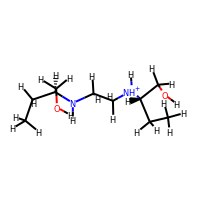
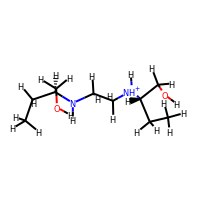
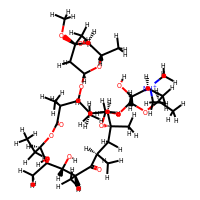
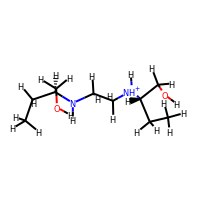

In [314]:
sim_infodf.head(2)

In [315]:
targetname = 'mostdilirank'
sim_infodf.to_pickle('results_descriptors_benchmark/sim_supervised_'+targetname+'.pkl.gz', compression='gzip')

## 5.3. Filtering

In [216]:
targetname = 'mostdilirank'
sim_infodf = pd.read_pickle('results_descriptors_benchmark/sim_supervised_'+targetname+'.pkl.gz', compression='gzip')

In [316]:
sim_filt_DF = sim_infodf[sim_infodf.parent_nonstd_inkey_source != sim_infodf.parent_nonstd_inkey_target]

In [317]:
sim_filt_DF.shape, sim_infodf.shape

((63252, 42), (63504, 42))

,parent_nonstd_inkey_source,parent_nonstd_inkey_target,mol3DProt_source,mol3DProt_target,cat_label_source,cat_label_target,cat_description_source,cat_description_target,cat_num_source,cat_num_target,atc_names_source,atc_names_target,vDILI_source,vDILI_target,jaccard_morganfp,jaccard_rdkit,jaccard_biofp,jaccard_morganfp_rdkit,jaccard_morganfp_biofp,jaccard_morganfp_rdkit_biofp,jaccard_rdkit_biofp,euclidean_morganfp,euclidean_rdkit,euclidean_biofp,euclidean_morganfp_rdkit,euclidean_morganfp_biofp,euclidean_morganfp_rdkit_biofp,euclidean_rdkit_biofp,cosine_morganfp,cosine_rdkit,cosine_biofp,cosine_morganfp_rdkit,cosine_morganfp_biofp,cosine_morganfp_rdkit_biofp,cosine_rdkit_biofp,cityblock_morganfp,cityblock_rdkit,cityblock_biofp,cityblock_morganfp_rdkit,cityblock_morganfp_biofp,cityblock_morganfp_rdkit_biofp,cityblock_rdkit_biofp
1,AGOYDEPGAOXOCK-YDSUDHQVNA-O,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,J,J,ANTIINFECTIVES FOR SYSTEMIC USE,ANTIINFECTIVES FOR SYSTEMIC USE,6,6,clarithromycin,ethambutol,1.0,1.0,0.092409,0.187500,0.200000,0.146093,0.099099,0.141989,0.175506,0.184938,0.286258,0.271477,0.345875,0.191268,0.247518,0.228756,0.428121,0.282921,0.0,0.336765,0.520860,0.449778,0.460831,0.314488,0.354027,0.333886,0.265443,0.248037,0.192005,0.224562
2,AHLBNYSZXLDEJQ-UMGWLCHRNA-N,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,A,J,ALIMENTARY TRACT AND METABOLISM,ANTIINFECTIVES FOR SYSTEMIC USE,0,6,orlistat,ethambutol,1.0,1.0,0.013889,0.205357,0.166667,0.157981,0.022634,0.154900,0.200036,0.120389,0.316299,0.470602,0.386324,0.293618,0.352297,0.331499,0.044739,0.191126,0.0,0.148344,0.417334,0.346517,0.406046,0.316628,0.472704,0.608406,0.391921,0.350361,0.380281,0.426127
3,AJXPJJZHWIXJCJ-LBPRGKRZNA-N,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,N,J,NERVOUS SYSTEM,ANTIINFECTIVES FOR SYSTEMIC USE,9,6,mesuximide,ethambutol,0.0,1.0,0.009563,0.169643,0.000000,0.158600,0.007937,0.157589,0.173459,0.200945,0.477729,0.304545,0.458997,0.331201,0.405439,0.432135,0.074184,0.221706,0.0,0.114976,0.056474,0.088626,0.166285,0.451950,0.652757,0.657278,0.516477,0.492655,0.517586,0.580371
4,ALOBUEHUHMBRLE-VWJBPIJRNA-O,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,C,J,CARDIOVASCULAR SYSTEM,ANTIINFECTIVES FOR SYSTEMIC USE,2,6,ibutilide,ethambutol,0.0,1.0,0.105235,0.223214,0.000000,0.199091,0.101562,0.197888,0.225662,0.180401,0.769304,0.304545,0.647778,0.325372,0.545545,0.622260,0.380200,0.672017,0.0,0.543414,0.243327,0.404513,0.458062,0.377087,0.744049,0.657278,0.581610,0.444338,0.577153,0.707308
5,ALVHFWNGOPERPY-QUMROSFINA-N,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,L,J,ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS,ANTIINFECTIVES FOR SYSTEMIC USE,7,6,sunitinib,ethambutol,1.0,1.0,0.019013,0.089286,0.333333,0.057465,0.034786,0.062063,0.097913,0.023349,0.515838,0.443592,0.453121,0.265478,0.404727,0.472339,0.184761,0.101701,0.0,0.172149,0.520700,0.459849,0.552860,0.099544,0.492214,0.602293,0.307538,0.206028,0.331736,0.477321
6,AMDBBAQNWSUWGN-SGWFYVIGNA-N,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,V,J,VARIOUS,ANTIINFECTIVES FOR SYSTEMIC USE,13,6,ioversol,ethambutol,0.0,1.0,0.065171,0.169643,0.000000,0.152285,0.062500,0.151612,0.173459,0.190027,0.475349,0.304545,0.438122,0.329967,0.385816,0.427381,0.244077,0.296355,0.0,0.276503,0.164139,0.208874,0.229258,0.392182,0.472655,0.657278,0.400354,0.460321,0.415710,0.470779
7,AQNDDEOPVVGCPG-GNIMXHHCNA-O,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,C,J,CARDIOVASCULAR SYSTEM,ANTIINFECTIVES FOR SYSTEMIC USE,2,6,esmolol,ethambutol,0.0,1.0,0.134199,0.232143,0.000000,0.216823,0.129747,0.215402,0.234362,0.284810,0.841564,0.304545,0.689975,0.359720,0.572404,0.641987,0.467918,0.835681,0.0,0.607186,0.295129,0.449762,0.520060,0.481281,0.840153,0.657278,0.665557,0.513971,0.652445,0.772024
8,AUZONCFQVSMFAP-UHFFFAOYNA-N,AEUTYOVWOVBAKS-YWVQUKSWNA-O,,,Comb,J,COMBINATION,ANTIINFECTIVES FOR SYSTEMIC USE,14,6,disulfiram,ethambutol,1.0,1.0,0.017296,0.294643,0.200000,0.256186,0.030172,0.252128,0.289768,0.192538,0.264647,0.306255,0.108394,0.246374,0.080196,0.208810,0.066350,0.255988,0.0,0.134638,0.382769,0.270796,0.410492,0.461249,0.580014,0.4
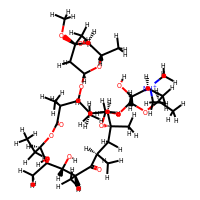
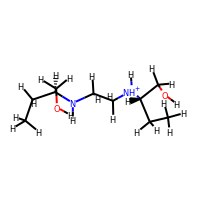
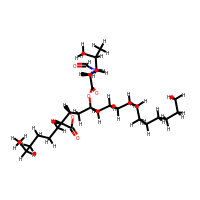
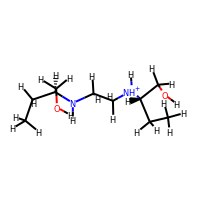
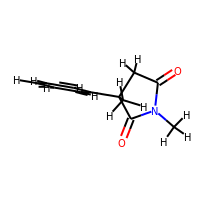
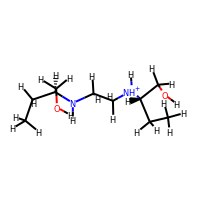
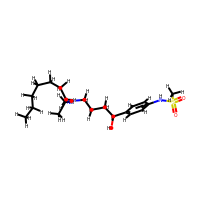
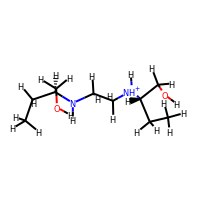
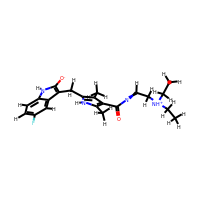
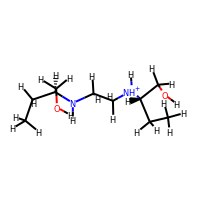
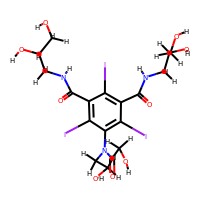
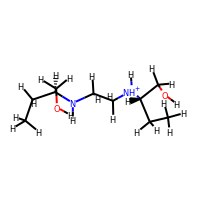
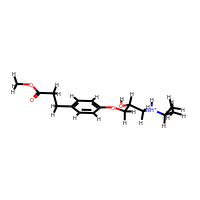
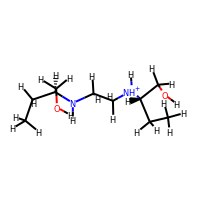
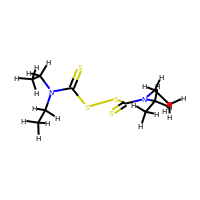
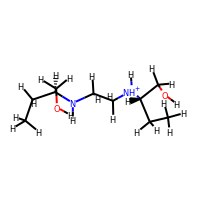
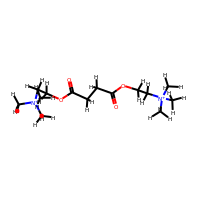
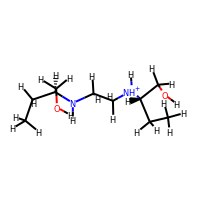
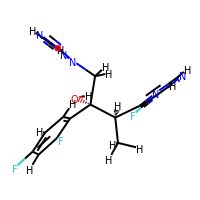
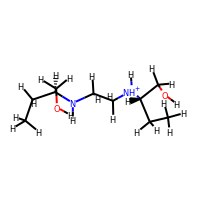

In [318]:
sim_filt_DF.head(10)

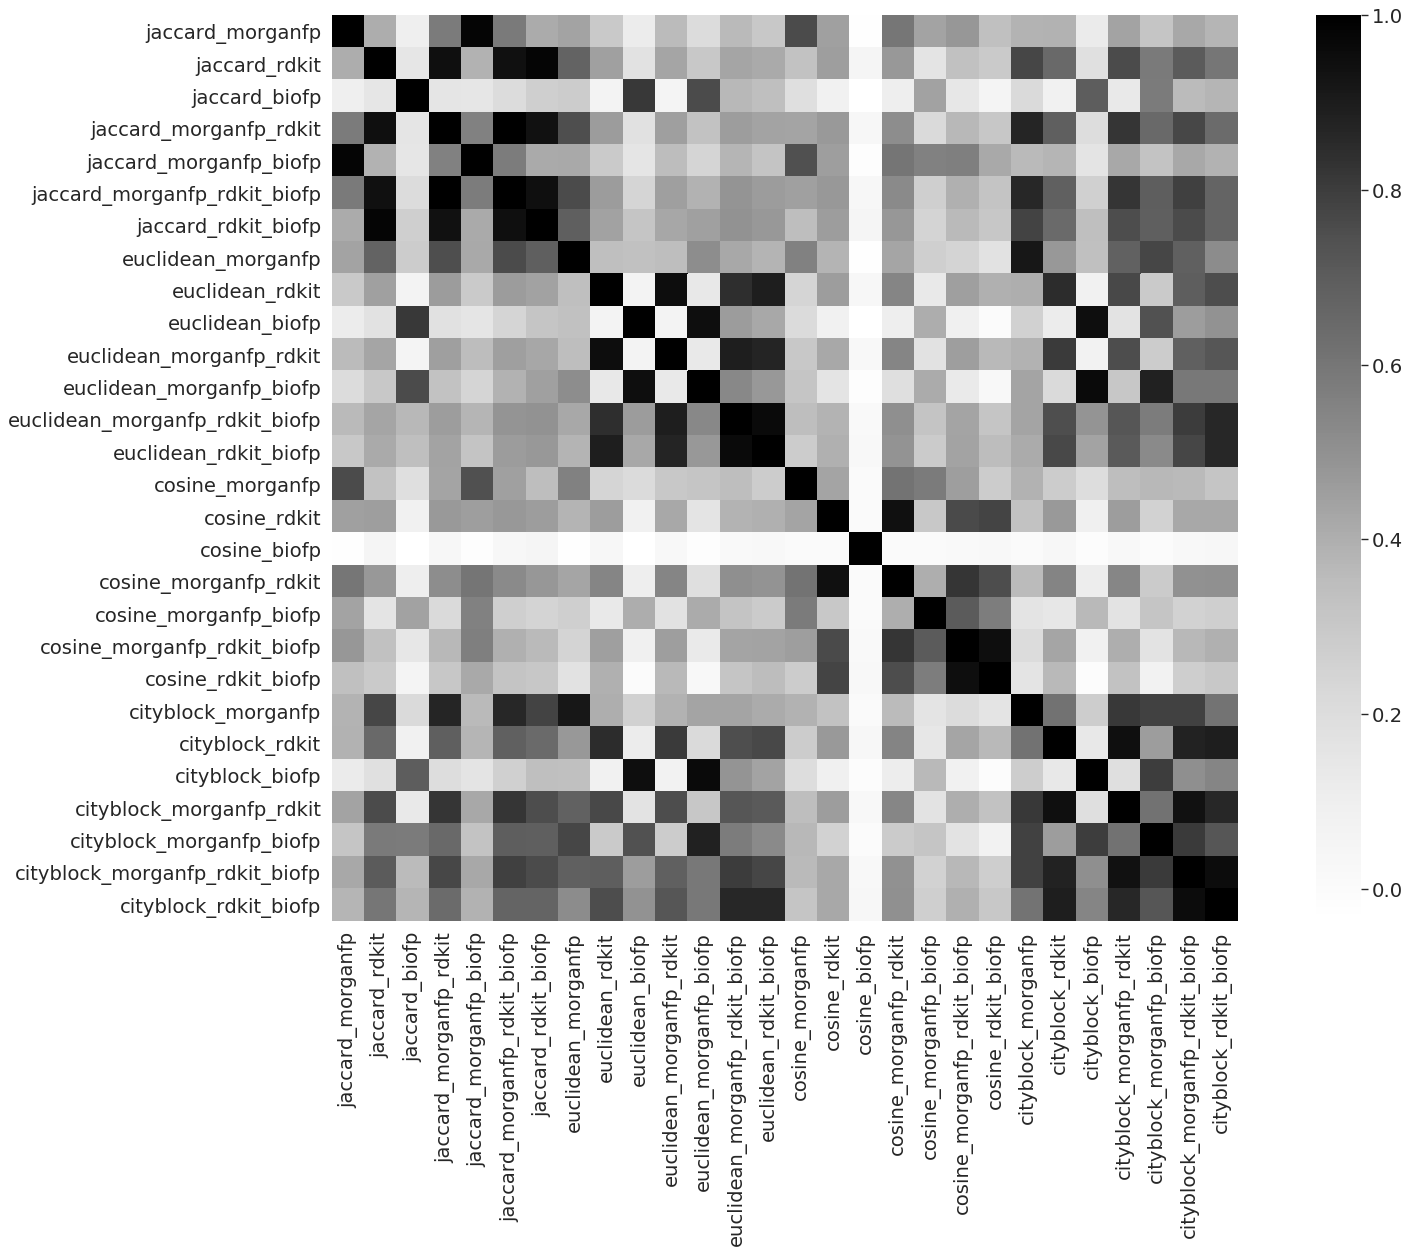

In [372]:
# Get the correlation matrix among side effects and plot it in a 
# heatmap
correlation = sim_filt_DF[simcols].corr()
sns.set(font_scale=1.6)
fig = plt.figure(figsize=(25, 15), dpi= 80, facecolor='w', edgecolor='k')
heatmap = sns.heatmap(correlation, cmap='Greys', square=True, annot=False)
fig.savefig('figures/correlationmatrix_heatmap.png',bbox_inches="tight")
# mask = np.zeros_like(correlation)
# mask[np.triu_indices_from(mask)] = True
# sns.set(font_scale=1.6)
# fig = plt.figure(figsize=(25, 15), dpi= 80, facecolor='w', edgecolor='k')
# with sns.axes_style("white"):
#     heatmap = sns.heatmap(correlation, cmap='Greys', mask = mask, square=True, annot=False)
#     fig.suptitle(sourcename+' vs '+targetname, fontsize=16)
#     fig.savefig(sourcename+'_vs_'+targetname+'_corrmatrix_fingerprints.png',bbox_inches="tight")

In [223]:
# Get consensus prediction. Here the rules to class assignment. 
def get_consensus(df):
    '''
    Add doc string explanation
    '''
    consensus = []
    for index, row in df.iterrows():
        val = 0
#         Get number of positive, negative and out of AD
#         predictions
        counts = row.value_counts().to_dict()
        if 1 in counts.keys():
            val = 1
            try:
                if counts[0] > counts[1]:
                    val = 0
            except:
                pass
        else:
            if 0 in counts.keys():
                val = 0
            else:
                val = 2

        consensus.append(val)
    return consensus

In [224]:
def getqualparameters(df, diliexp, dilipred):
    FP = df[(df[diliexp] == 0) & (df[dilipred] == 1)].shape[0]
    FN = df[(df[diliexp] == 1) & (df[dilipred] == 0)].shape[0]
    TP = df[(df[diliexp] == 1) & (df[dilipred] == 1)].shape[0]
    TN = df[(df[diliexp] == 0) & (df[dilipred] == 0)].shape[0]

    try:
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
    except:
        TPR = 0
    try:
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
    except:
        TNR = 0
    try:
        # Overall accuracy (bioisosters percentage)
        ACC = (TP+TN)/(TP+FP+FN+TN)
    except:
        ACC = 0
    try:
        # activity cliffs percentage
        actcliffs = (FP+FN)/(TP+FP+FN+TN)
    except:
        actcliffs = 0
    
    try:
        from sklearn.metrics import matthews_corrcoef
        mcc = matthews_corrcoef(df[diliexp], df[dilipred])
    except:
        mcc = 0
    return ( TP, TN, FP, FN, TPR, TNR, mcc, ACC, actcliffs)

In [229]:
def get_general_simquality(frame, dilitrain, dilitest, trainname, testname, simcol, biocols):
   
    simqual_trcon_df = pd.DataFrame([])
    for i in np.arange(0.0, 0.95, 0.05):
        df = frame[(frame[trainname] != frame[testname])&
                   (frame[simcol] >= i)]
#         df = frame[(frame[simcol] >= i)] ## this does not filter same test and train compounds

        df = df.replace('nan', 2)
        df = df.fillna(2)

        df[biocols] = df[biocols].astype(float)
        df[biocols] = df[biocols].astype(int)

        valdf = pd.DataFrame([],columns=['name'])
        count = 0
        for pinkey in df[testname].unique():
            count += 1
            dtest = df.loc[df[testname] == pinkey,dilitest].values[0]
            dtrain = df[df[testname].isin([pinkey])][[dilitrain]].mean(numeric_only=True)

            valdf.loc[count,'name'] = pinkey
            valdf.loc[count, dilitest] = dtest
            if dtrain.values[0] > 0.55:
                valdf.loc[count,dilitrain+'_consensus'] = int(1)
            elif dtrain.values[0] < 0.45:
                valdf.loc[count,dilitrain+'_consensus'] = int(0)
            else:
                valdf.loc[count,dilitrain+'_consensus'] = int(2) 
        try:
            TP, TN, FP, FN, TPR, TNR, mcc, ACC, actcliffs = getqualparameters(valdf,
                                                                              dilitest,
                                                                              dilitrain+'_consensus')
        except:
            TP, TN, FP, FN, TPR, TNR, mcc, ACC, actcliffs = [0,0,0,0,0,0,0,0,0]

        simqual_trcon_df = simqual_trcon_df.append([[i,len(valdf), TP, TN, FP, FN, 
                                                     TPR, TNR, mcc,
                                                     ACC, actcliffs]])
       
    simqual_trcon_df.columns = ['simcutoff','mols',
                                'TP', 'TN', 'FP', 'FN',
                                'sens', 'spec', 'mcc',
                                'bioisosters', 'actcliffs']
    floatcols = ['sens', 'spec', 'mcc', 'bioisosters', 'actcliffs']
    simqual_trcon_df[floatcols] = simqual_trcon_df[floatcols].round(2)
    intcols = ['mols','TP', 'TN', 'FP', 'FN']
    simqual_trcon_df[intcols] = simqual_trcon_df[intcols].astype(int)
    simqual_trcon_df.reset_index(drop=True,inplace=True)
    return(simqual_trcon_df)


In [226]:
def get_simqual_plot(frame):
    sns.set_style('white')
    df = frame.copy()
    df = df.set_index('simcutoff')
    cols = df.columns.drop(['mols', 'TP', 'TN', 'FP', 'FN'])
    ax = df[cols].plot(figsize=(15,10))
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.set_xlabel("similarity cutoff")
#     ax.set_ylabel("quality parameters")

In [227]:
bcols = ['vDILI_source', 'vDILI_target']

In [230]:
df = sim_filt_DF.copy()
dilipred = 'vDILI_source'
diliexp = 'vDILI_target'
trainname = 'parent_nonstd_inkey_source'
testname = 'parent_nonstd_inkey_target'
# simfactorplotDF = pd.DataFrame(simcols, columns=['sim_metric'])
simcombDF = pd.DataFrame([])
for i in simcols:
    print ('we comence', i)
    simcol = i
    tempsimDF = get_general_simquality(df, dilipred, diliexp,
                                       trainname, testname, simcol, bcols)
    tempsimDF.loc[:,'metric'] = i
    simcombDF = pd.concat([simcombDF,tempsimDF], axis=0)
    print ('we finalize', i)

we comence jaccard_morganfp


/home/kpinto/miniconda3/envs/flame/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


we finalize jaccard_morganfp
we comence jaccard_rdkit
we finalize jaccard_rdkit
we comence jaccard_volsurf
we finalize jaccard_volsurf
we comence jaccard_biofp
we finalize jaccard_biofp
we comence jaccard_morganfp_rdkit
we finalize jaccard_morganfp_rdkit
we comence jaccard_morganfp_vsurf
we finalize jaccard_morganfp_vsurf
we comence jaccard_morganfp_biofp
we finalize jaccard_morganfp_biofp
we comence jaccard_morganfp_rdkit_biofp
we finalize jaccard_morganfp_rdkit_biofp
we comence jaccard_morganfp_vsurf_biofp
we finalize jaccard_morganfp_vsurf_biofp
we comence jaccard_rdkit_biofp
we finalize jaccard_rdkit_biofp
we comence jaccard_vsurf_biofp
we finalize jaccard_vsurf_biofp
we comence euclidean_morganfp
we finalize euclidean_morganfp
we comence euclidean_rdkit
we finalize euclidean_rdkit
we comence euclidean_volsurf
we finalize euclidean_volsurf
we comence euclidean_biofp
we finalize euclidean_biofp
we comence euclidean_morganfp_rdkit
we finalize euclidean_morganfp_rdkit
we comence eucli

In [231]:
simcombDF.reset_index(drop=True, inplace=True)

In [326]:
simqualDF = simcombDF[(~simcombDF.metric.str.contains('vsurf')) & (~simcombDF.metric.str.contains('volsurf'))].reset_index(drop=True)


In [327]:
simqualDF.to_pickle('results_descriptors_benchmark/sim_supervised_quality_table.pkl')

In [233]:
simqualDF = pd.read_pickle('results_descriptors_benchmark/sim_supervised_quality_table.pkl')

In [328]:
simqualDF.head(20)

,simcutoff,mols,TP,TN,FP,FN,sens,spec,mcc,bioisosters,actcliffs,metric
0,0.00,252,0,151,1,100,0.00,0.99,-0.05,0.60,0.40,jaccard_morganfp
1,0.05,252,4,146,2,84,0.05,0.99,0.13,0.64,0.36,jaccard_morganfp
2,0.10,252,12,135,1,76,0.14,0.99,0.16,0.66,0.34,jaccard_morganfp
3,0.15,252,25,128,11,62,0.29,0.92,0.22,0.68,0.32,jaccard_morganfp
4,0.20,227,44,127,12,30,0.59,0.91,0.49,0.80,0.20,jaccard_morganfp
5,0.25,177,37,106,4,16,0.70,0.96,0.60,0.88,0.12,jaccard_morganfp
6,0.30,133,25,90,4,6,0.81,0.96,0.68,0.92,0.08,jaccard_morganfp
7,0.35,99,18,69,2,7,0.72,0.97,0.68,0.91,0.09,jaccard_morganfp
8,0.40,72,17,50,1,3,0.85,0.98,0.83,0.94,0.06,jaccard_morganfp
9,0.45,56,10,44,0,1,0.91,1.00,0.89,0.98,0.02,jaccard_morganfp


# ALL Metrics

# Plots by Metrics

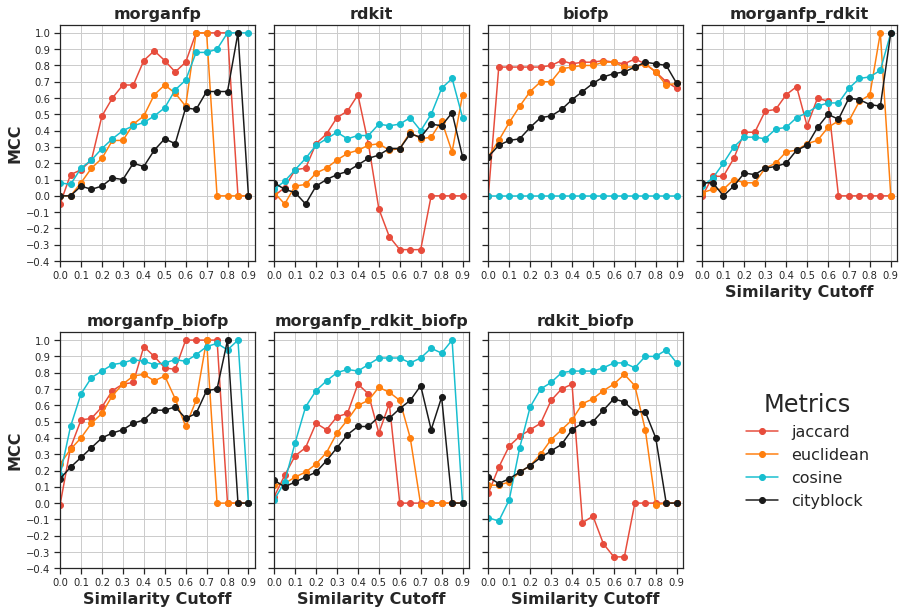

In [368]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7,ax8)) = plt.subplots(2,4, sharey=True, sharex=False, figsize=(15,15))
fig.subplots_adjust(hspace=0.30, wspace=0.1)

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

sns.set(font_scale = 2.0)
sns.set_style("ticks")
mypal = ["#e74c3c",'#ff7f0e', '#17becf','#9467bd', '#2ca02c','#c7c7c7', '#ffff33',"#3498db"]
sns.set_palette(mypal)

# sns.color_palette("husl", 11)
# sns.set(font_scale = 2.0)
# sns.set_style("ticks")
# sns.set_palette(sns.color_palette("husl", 11))
mt = ['jaccard', 'euclidean', 'cosine', 'cityblock']
for i, j in zip(axes, oknames):
    df = simqualDF[simqualDF.metric.str.endswith(j)].copy()
    df = df.set_index('simcutoff')
    cols = ['mcc','metric']
    df = df[cols]
    for k in mt:
        tempdf = df[df.metric == k+'_'+j]
        if k == 'cityblock':
            ax = tempdf['mcc'].plot(figsize=(15,10),style="-o",ax=i,
                                    color='k', legend=None, fontsize=10)
        else:
            ax = tempdf['mcc'].plot(figsize=(15,10),style="-o",ax=i, legend=None, fontsize=10)

        ax.set_title(str(j), fontsize=16, fontweight='bold')
        ax.set_xlabel('')
        ax.xaxis.set_ticks(np.arange(0, 1.0, step=0.1))
        ax.yaxis.set_ticks(np.arange(-1.1, 1.1, step=0.1))
        ax.grid(axis='both')
        if i in [ax4, ax5, ax6, ax7]:
            ax.set_xlabel('Similarity Cutoff', fontsize=16, fontweight='bold')
        ax.set_ylabel('MCC', fontsize=16, fontweight='bold')
        ax.set_visible(True)
        if i == ax7:
            ax.legend(labels = mt, loc='center left', title='Metrics',
                      bbox_to_anchor=(1.25, 0.5), frameon=False,
                      fontsize=16)
        ax.set_ylim(-0.40,1.05)
        ax.set_xlim(0,0.93)
fig.delaxes(ax8)
fig.savefig("figures/supervised-metrics_per_descriptors-MCC.png", bbox_inches="tight")

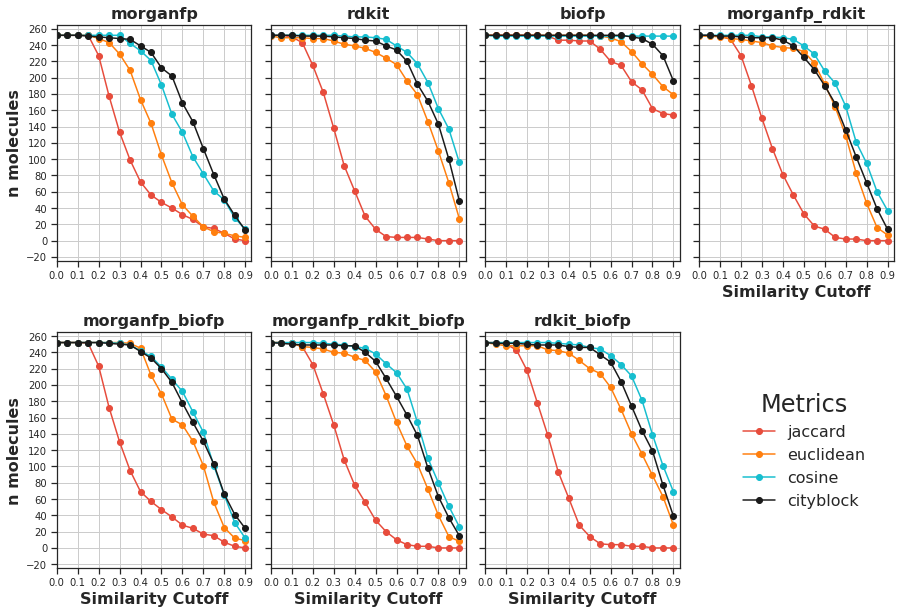

In [367]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7,ax8)) = plt.subplots(2,4, sharey=True, sharex=False, figsize=(15,15))
fig.subplots_adjust(hspace=0.30, wspace=0.1)

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

sns.set(font_scale = 2.0)
sns.set_style("ticks")
mypal = ["#e74c3c",'#ff7f0e', '#17becf','#9467bd', '#2ca02c','#c7c7c7', '#ffff33',"#3498db"]
sns.set_palette(mypal)

# sns.color_palette("husl", 11)
# sns.set(font_scale = 2.0)
# sns.set_style("ticks")
# sns.set_palette(sns.color_palette("husl", 11))
mt = ['jaccard', 'euclidean', 'cosine', 'cityblock']
for i, j in zip(axes, oknames):
    df = simqualDF[simqualDF.metric.str.endswith(j)].copy()
    df = df.set_index('simcutoff')
    cols = ['mols','metric']
    df = df[cols]
    for k in mt:
        tempdf = df[df.metric == k+'_'+j]
        if k == 'cityblock':
            ax = tempdf['mols'].plot(figsize=(15,10),style="-o",ax=i,
                                    color='k', legend=None, fontsize=10)
        else:
            ax = tempdf['mols'].plot(figsize=(15,10),style="-o",ax=i, legend=None, fontsize=10)

        ax.set_title(str(j), fontsize=16, fontweight='bold')
        ax.set_xlabel('')
        ax.xaxis.set_ticks(np.arange(0, 1.0, step=0.1))
        ax.yaxis.set_ticks(np.arange(-20, 280, step=20))
        ax.grid(axis='both')
        if i in [ax4, ax5, ax6, ax7]:
            ax.set_xlabel('Similarity Cutoff', fontsize=16, fontweight='bold')
        ax.set_ylabel('n molecules', fontsize=16, fontweight='bold')
        ax.set_visible(True)
        if i == ax7:
            ax.legend(labels = mt, loc='center left', title='Metrics',
                      bbox_to_anchor=(1.25, 0.5), frameon=False,
                      fontsize=16)
        ax.set_ylim(-25,265)
        ax.set_xlim(0,0.93)
fig.delaxes(ax8)
fig.savefig("figures/supervised-metrics_per_descriptors-molecules.png", bbox_inches="tight")

# Plots by Descriptors combination

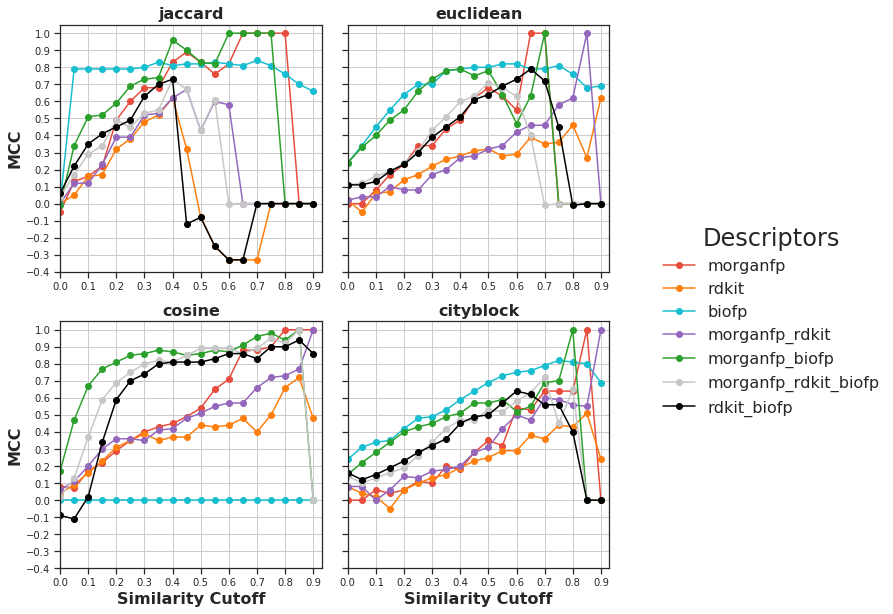

In [369]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, sharey=True, sharex=False, figsize=(15,15))
fig.subplots_adjust(hspace=0.20, wspace=0.1)

axes = [ax1, ax2, ax4, ax5]
sns.set(font_scale = 2.0)
sns.set_style("ticks")
mypal = ["#e74c3c",'#ff7f0e', '#17becf','#9467bd', '#2ca02c','#c7c7c7', '#ffff33',"#3498db"]
sns.set_palette(mypal)
# sns.color_palette("husl", 11)
# sns.set(font_scale = 2.0)
# sns.set_style("ticks")
# sns.set_palette(sns.color_palette("husl", 11))
for i, m in zip(axes, mt):
    df = simqualDF[simqualDF.metric.str.contains(m)]
    df = df.set_index('simcutoff')
    cols = ['mcc','metric']
    df = df[cols]
    for j in oknames:
        tempdf = df[df.metric == m+'_'+j]
        if j =='rdkit_biofp':
            ax = tempdf['mcc'].plot(figsize=(15,10),style="-o", color='black',
                                    ax=i, legend=None, fontsize=10)
        else:   
            ax = tempdf['mcc'].plot(figsize=(15,10),style="-o",
                                    ax=i, legend=None, fontsize=10)
        ax.set_title(m, fontsize=16, fontweight='bold')
        ax.set_xlim(0,0.93)
        ax.set_xlabel('')
        ax.xaxis.set_ticks(np.arange(0, 1.0, step=0.1))
        ax.yaxis.set_ticks(np.arange(-1.1, 1.1, step=0.1))
        ax.grid(axis='both')
        if i in [ax4, ax5]:
            ax.set_xlabel('Similarity Cutoff', fontsize=16, fontweight='bold')
        ax.set_ylabel('MCC', fontsize=16, fontweight='bold')
        ax.set_visible(True)
        if i == ax5:
            ax.legend(labels = oknames,
                      loc='center left', bbox_to_anchor=(1.15,1.00),
                      frameon=False, fontsize=16, title='Descriptors')
        ax.set_ylim(-0.40,1.05)
        ax.set_xlim(0,0.93)
fig.delaxes(ax6)
fig.delaxes(ax3)
fig.savefig("figures/supervised-descriptors_per_metrics-MCC.png", bbox_inches="tight")

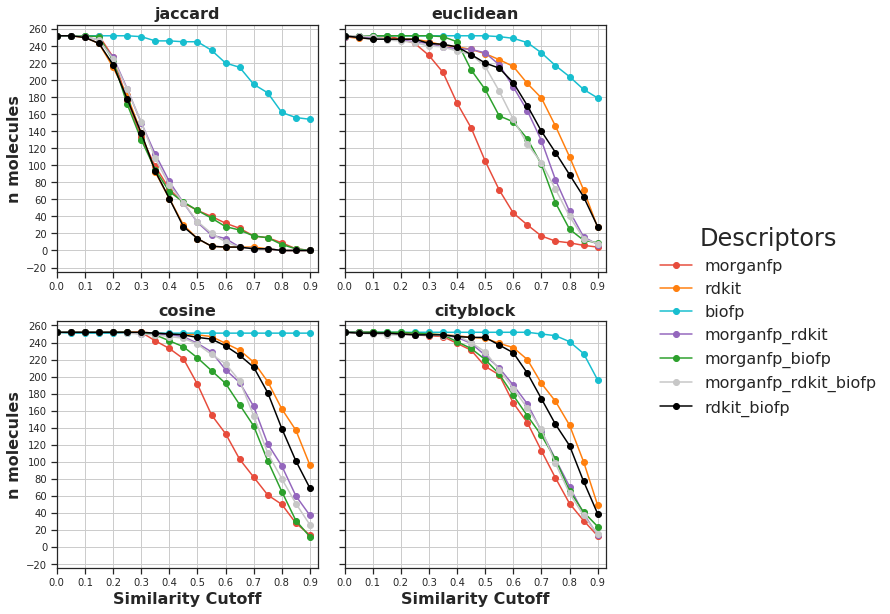

In [370]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, sharey=True, sharex=False, figsize=(15,15))
fig.subplots_adjust(hspace=0.20, wspace=0.1)

axes = [ax1, ax2, ax4, ax5]
sns.set(font_scale = 2.0)
sns.set_style("ticks")
mypal = ["#e74c3c",'#ff7f0e', '#17becf','#9467bd', '#2ca02c','#c7c7c7', '#ffff33',"#3498db"]
sns.set_palette(mypal)
# sns.color_palette("husl", 11)
# sns.set(font_scale = 2.0)
# sns.set_style("ticks")
# sns.set_palette(sns.color_palette("husl", 11))
for i, m in zip(axes, mt):
    df = simqualDF[simqualDF.metric.str.contains(m)]
    df = df.set_index('simcutoff')
    cols = ['mols','metric']
    df = df[cols]
    for j in oknames:
        tempdf = df[df.metric == m+'_'+j]
        if j =='rdkit_biofp':
            ax = tempdf['mols'].plot(figsize=(15,10),style="-o", color='black',
                                    ax=i, legend=None, fontsize=10)
        else:   
            ax = tempdf['mols'].plot(figsize=(15,10),style="-o",
                                    ax=i, legend=None, fontsize=10)
        ax.set_title(m, fontsize=16, fontweight='bold')
#         ax.set_xlim(0,0.93)
        ax.set_xlabel('')
        ax.xaxis.set_ticks(np.arange(0, 1.0, step=0.1))
        ax.yaxis.set_ticks(np.arange(-20, 280, step=20))
        ax.grid(axis='both')
        if i in [ax4, ax5]:
            ax.set_xlabel('Similarity Cutoff', fontsize=16, fontweight='bold')
        ax.set_ylabel('n molecules', fontsize=16, fontweight='bold')
        ax.set_visible(True)
        if i == ax5:
            ax.legend(labels = oknames,
                      loc='center left', bbox_to_anchor=(1.15,1.00),
                      frameon=False, fontsize=16, title='Descriptors')
        ax.set_ylim(-25,265)
        ax.set_xlim(0,0.93)
fig.delaxes(ax6)
fig.delaxes(ax3)
fig.savefig("figures/supervised-descriptors_per_metrics-molecules.png", bbox_inches="tight")